# Permutation Importance Documentation

`scikit-explain` includes [single-pass](https://christophm.github.io/interpretable-ml-book/feature-importance.html), [multi-pass](https://journals.ametsoc.org/view/journals/bams/100/11/bams-d-18-0195.1.xml), [second-order](https://www.mdpi.com/2076-3417/9/23/5191), and [grouped permutation importance](https://arxiv.org/abs/2104.11688), respectively. In this notebook, we highlight how to compute these methods and plot their results.  In the first set of examples, two tree-based models (random forest and gradient-boosting) and logistic regression from scikit-learn were trained on a portion of the road surface temperature data from [Handler et al. (2020)](https://journals.ametsoc.org/view/journals/wefo/35/5/wafD190159.xml). The goal is to predict whether road surface temperatures will be above or below freezing (32 F) in the next hour. This dataset has 100 K examples with a class skew of 39%.

A regression-based example is also shown using the Californina housing dataset available in scikit-learn. 

In [1]:
import sys, os 
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import skexplain
import plotting_config 

### Loading the training data and pre-fit models for the classification problem

In [3]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()

print(estimators)
print(f'X Shape : {X.shape}')
print(f'y Skew : {y.mean()*100}%')

[('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5)), ('Gradient Boosting', GradientBoostingClassifier()), ('Logistic Regression', LogisticRegression(C=1))]
X Shape : (100000, 30)
y Skew : 39.173%


# ExplainToolkit

`ExplainToolkit` is the main interface of `scikit-explain`. After initializing `ExplainToolkit` with an estimator and some data, all the explainability methods and their respective plotting modules are called from `ExplainToolkit`. 
To initialize `ExplainToolkit` requires: 

* `estimators`, a tuple of (estimator name, pre-fit estimator object) (or list thereof).
* `X` and `y` (to evaluate the model on)
    * Can be `pandas.DataFrame` or `numpy.array`. If you use an `numpy.array`, then you must provide the feature names (`'feature_names'`).

In [5]:
explainer = skexplain.ExplainToolkit(estimators=estimators, X=X, y=y,)

## Permutation Importance

Feature/predictor ranking is often a first step in model interpretability and a popular model-agnostic approach is the permutation importance method. In this method the data for each feature is permuted (shuffled) and the permuted feature causing the greatest loss of skill (based on some error metric) is deemed the most important (and each feature is ranked subsequently). This describes what is known as the single-pass permuation importance method (McGovern et al. 2019; Fig 1. @ https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance for an illustration). This method is appropriate for datasets with independent features (where little to no correlations exist between features). For datasets with physical or statistically dependent features, the more reliable method 
is the multi-pass permutation method (Lakshmanan et al. 2015, JOAT; see Fig.2 @ the above link) where the top feature remains permuted before assessing the second most important predictor, and so on for the third predictor and beyond.
By keeping features permuted, it ought to break the interfeature correlations. 

`scikit-explain` uses a stripped-down version of the python package `PermutationImportance` to compute both the single and multipass permutation importance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). 

`skexplain.calc_permutation_importance` requires the following args:
* `n_vars`, the number of predictor to compute for the multi-pass method.
* `evaluation_fn`, the error function used to assess loss of skill.
    * `mintpy` has 5 built-in error metrics for evaluating predictor importance: 
        * Area under the Curve (`'auc'`)
        * Area under the Precision-Recall Curve (`'aupdrc'`)
        * Normalized Area under the Performance Diagram Curve (`'norm_aupdc'`)
        * Brier Skill Score (`'bss'`)
        * Mean Square Error (`'mse'`) 
* `n_permute`, number of times to repeat permutations for confidence intervals
* `subsample`, can be a float between 0-1 or an integer, which is interpreted as the percentage of examples or exact number of random samples to use, respectively. 
* `n_jobs`, number of processor to run the script on.
    * Could be the exact number or percentage of the total available to use (0-1) similar to subsample
* `verbose`, allows for a print out of the progress.
* `random_state`,  Pass an int to get reproducible results across function calls.
* `direction`, Whether features are progressively unpermuted (`'forward'`) or features are left permuted for second-, third-most important features (`'backward'`). The results are often not identical. 
   
__Note__: `evaluation_fn` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy argument. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if it is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 


In this example, we want to know the top 10 predictors for all of our models. We are using normalized area under the precision-recall curve (NAUPDC; Flora et al. 2021) as the error metric. To produce confidence intervals, we are using 5 bootstrap iterations (kept small for illustration purposes, but should typically be 100-1000). The multipass permutation importance method can be computationally expensive for larger datasets or computing for a large number of top predictors. Thus, we've included a method to `skexplain` to store the results for later use. The results are stored in `xarray.Dataset`s and saved as netcdf files. 

In [5]:
results = explainer.permutation_importance(
                                           n_vars=10, 
                                           evaluation_fn='norm_aupdc',
                                           n_permute=10, 
                                           subsample=0.25,
                                           n_jobs=8,
                                           verbose=True,
                                           random_seed=42, 
                                           direction='backward',
                                              )

# Save the permutation importance results as a netcdf file using the bulit-in function within mintpy
explainer.save(fname='multipass_importance_naupdc.nc', data=results)

Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out of 10...
Multi-pass iteration 9 out of 10...
Multi-pass iteration 10 out of 10...
Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out of 10...
Multi-pass iteration 9 out of 10...
Multi-pass iteration 10 out of 10...
Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out

### Re-loading results 

There are I/O methods built into `scikit-explain` that allows for loading and saving `ExplainToolikit` results. For example, we might want one script for computing the explainability results and another for loading them to plot the results. To do so, we initialize an empty `ExplainToolkit` and call the `load` method. Their are attributes saved in each output netCDF file that are used as an attributes for `ExplainToolkit`, which makes using `scikit-explain` more streamlined. Though it is not demonstrated here, you can also pass a list of filenames and the datasets are merged into one when being loaded. 

In [4]:
explainer = skexplain.ExplainToolkit()
# Load the results file; gets load as a class attribute 
results = explainer.load(fnames='multipass_importance_naupdc.nc')

## Plotting Single-Pass Permutation Importance 


The first iteration of the multi-pass permutation method is the single-pass method and is therefore saved by default.
Feature ranking plotting in `scikit-explain` is highly flexible, so if we want show multiple panels, then we need to declare what to show in each panel (i.e., (method, estimator name)). For example, to only plot the singlepass results from the random forest, we set ``panels=[('singlepass', 'Random Forest')]``. The single-pass method ranks all features, so for readability, you can set `num_vars_to_plot` (default=15). 

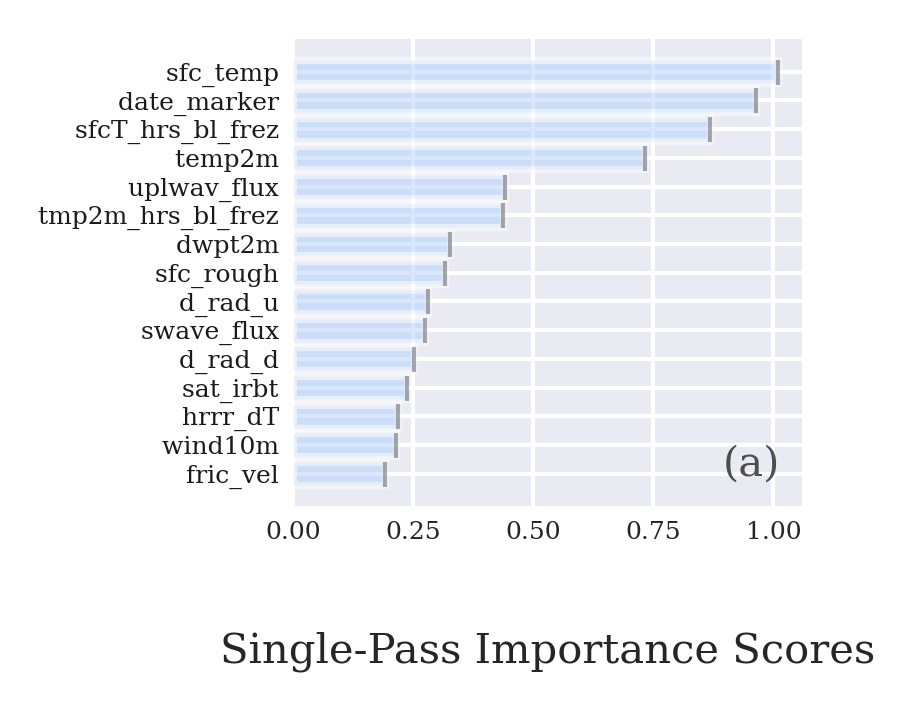

In [5]:
fig = explainer.plot_importance(data=results, 
                                panels=[('singlepass', 'Random Forest')], 
                                num_vars_to_plot=15, 
                                 )

### Changing the x-axis label

By default, skexplain uses the method name given as the x-axis label. However, we can also pass in ``xlabels`` for custom x-axis labeling. In this case, we might just want "Single-Pass". 

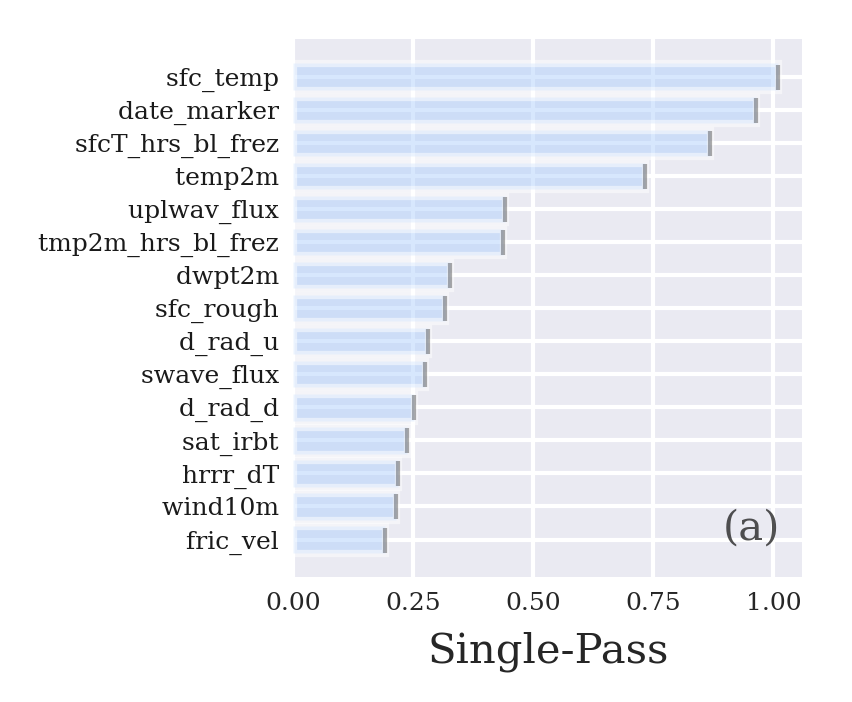

In [6]:
fig = explainer.plot_importance(data=results, 
                                panels=[('singlepass', 'Random Forest')], 
                                num_vars_to_plot=15, 
                                xlabels = ['Single-Pass']
                                 )

### Plotting results from multiple estimators

We computed permutation importance results for 3 different ML models and we can display them in a single plot by adding to the `panels` arg. </div> <div class="alert alert-block alert-warning"><b>Warning: When using multiple panels, len(panels)==len(data). In this case, I repeat the same dataset 3 times. If you wanted to plot single-pass and multi-pass, the dataset would need to be repeated twice. </b> 


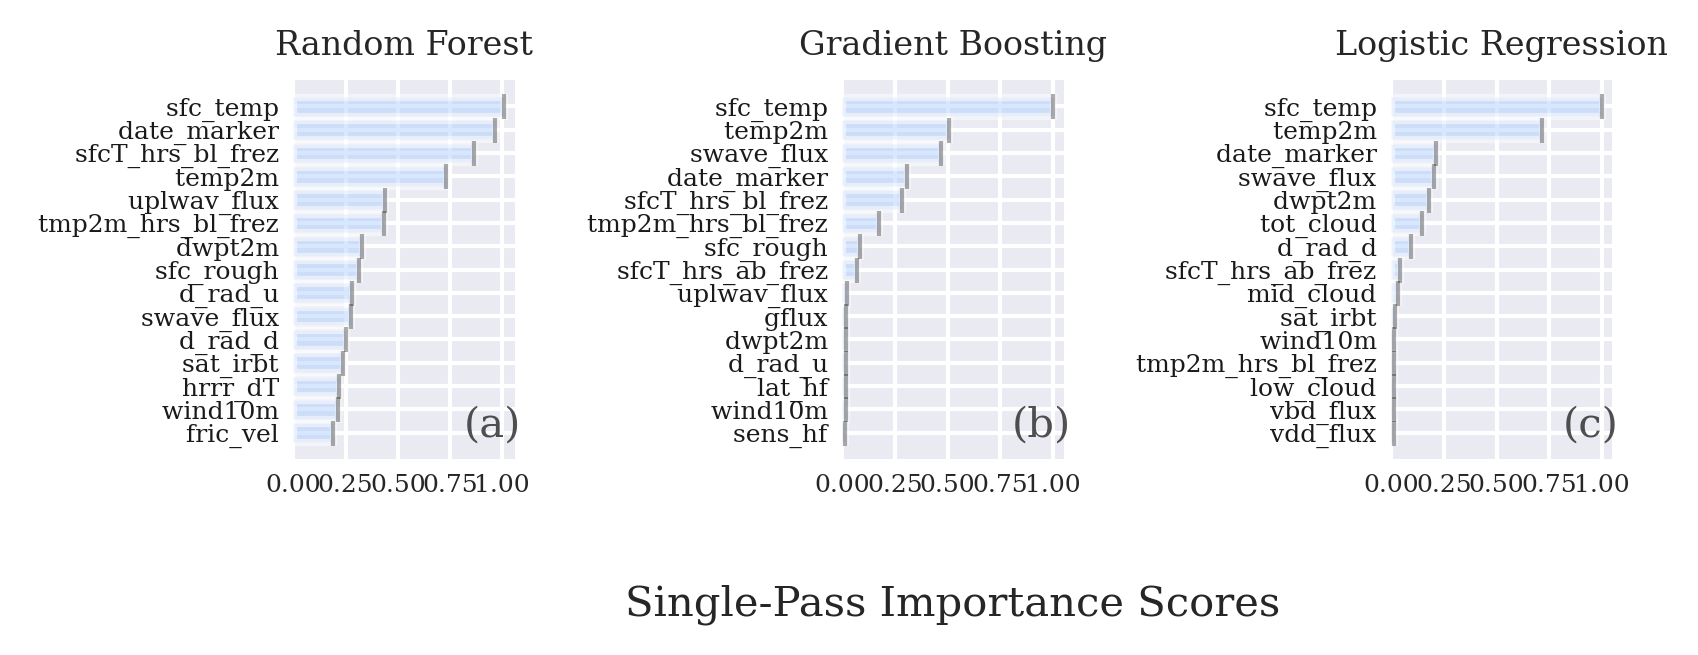

In [7]:
fig = explainer.plot_importance(data=[results]*3, 
                                panels=[('singlepass', 'Random Forest'), 
                                        ('singlepass', 'Gradient Boosting'), 
                                        ('singlepass', 'Logistic Regression'), 
                                       ],
                                num_vars_to_plot=15, )

### Changing the facecolor

By default, skexplain uses a light blue color for the facecolors. The user, though, does have the option to provide a different color using ``feature_colors``, which can be a single color or as we will see below a dictionary that could map individual features to particular colors (e.g., if features can be clustered). 

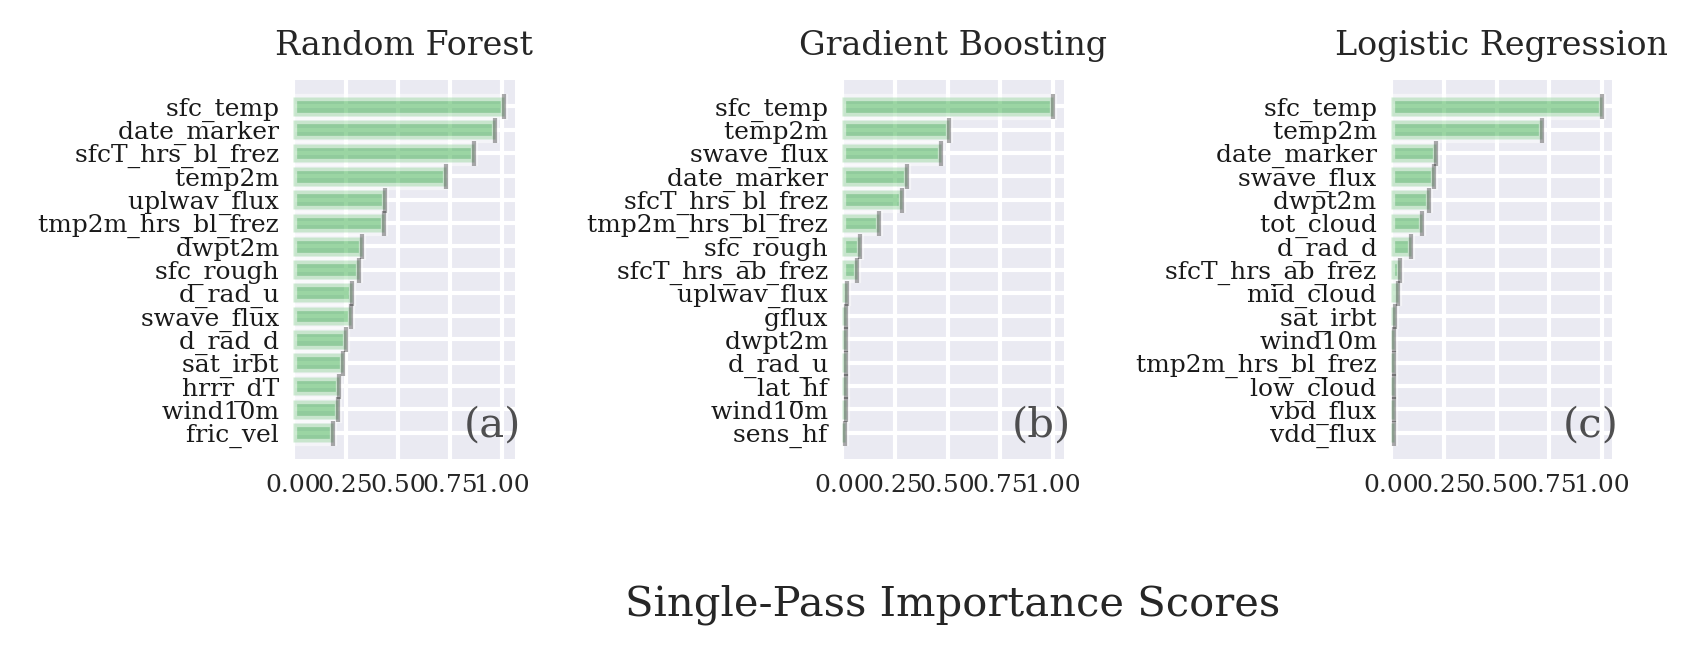

In [8]:
fig = explainer.plot_importance(
                                data=[results]*3, 
                                panels=[('singlepass', 'Random Forest'), 
                                        ('singlepass', 'Gradient Boosting'), 
                                        ('singlepass', 'Logistic Regression'), 
                                       ],
                                num_vars_to_plot=15,
                                feature_colors = 'xkcd:medium green'
                                    )

## Plotting Multi-Pass Permutation Importance 

To plot the multi-pass results, simply changing the method (the first part of the tuple) to ``multipass``. 


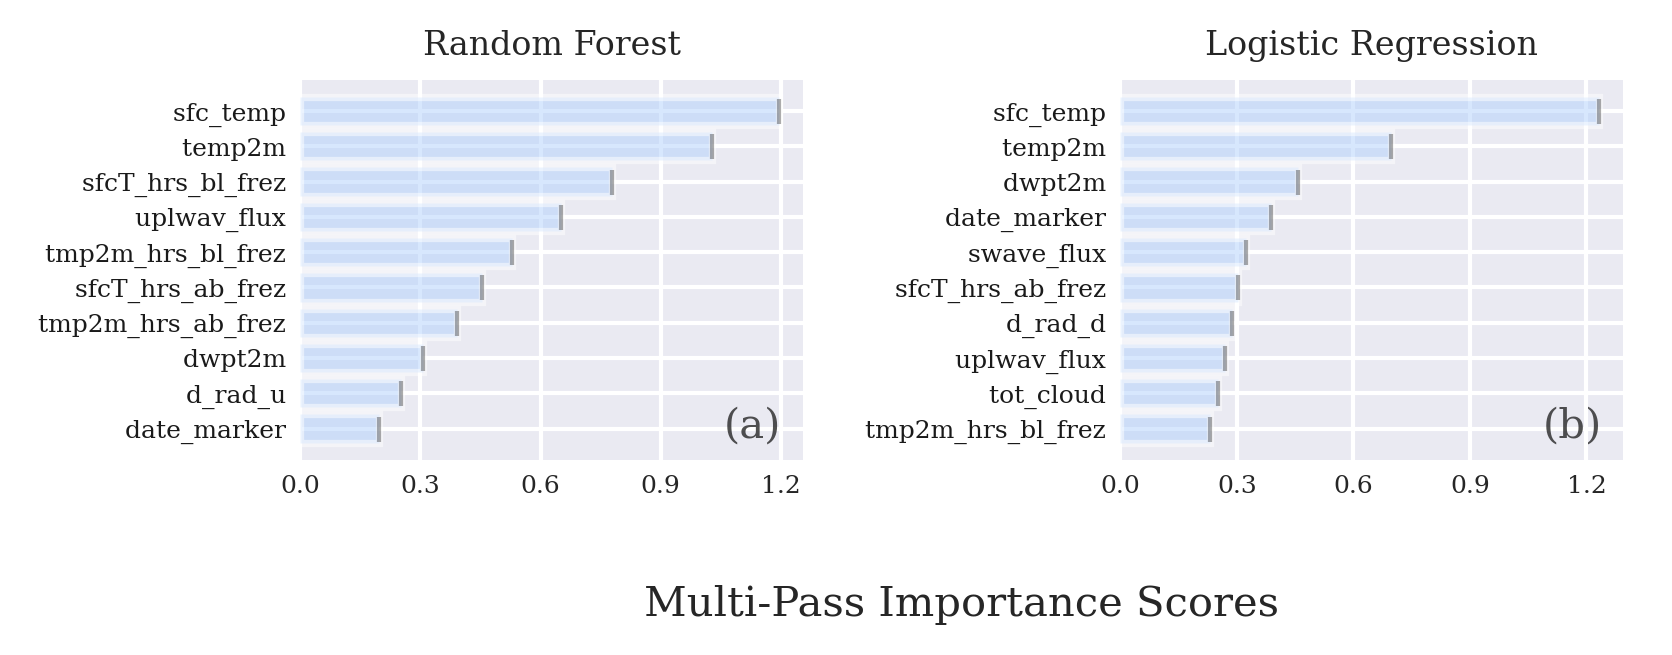

In [9]:
fig = explainer.plot_importance(data=[results]*2, 
                                panels=[('multipass', 'Random Forest'), 
                                        ('multipass', 'Logistic Regression'), 
                                       ], num_vars_to_plot=10,)

### Compare Multi-pass vs. Single-pass

We can also plot results from different ranking methods. In this example, we can compare the multi-pass vs. the single-pass permutation importance for the random forest. 

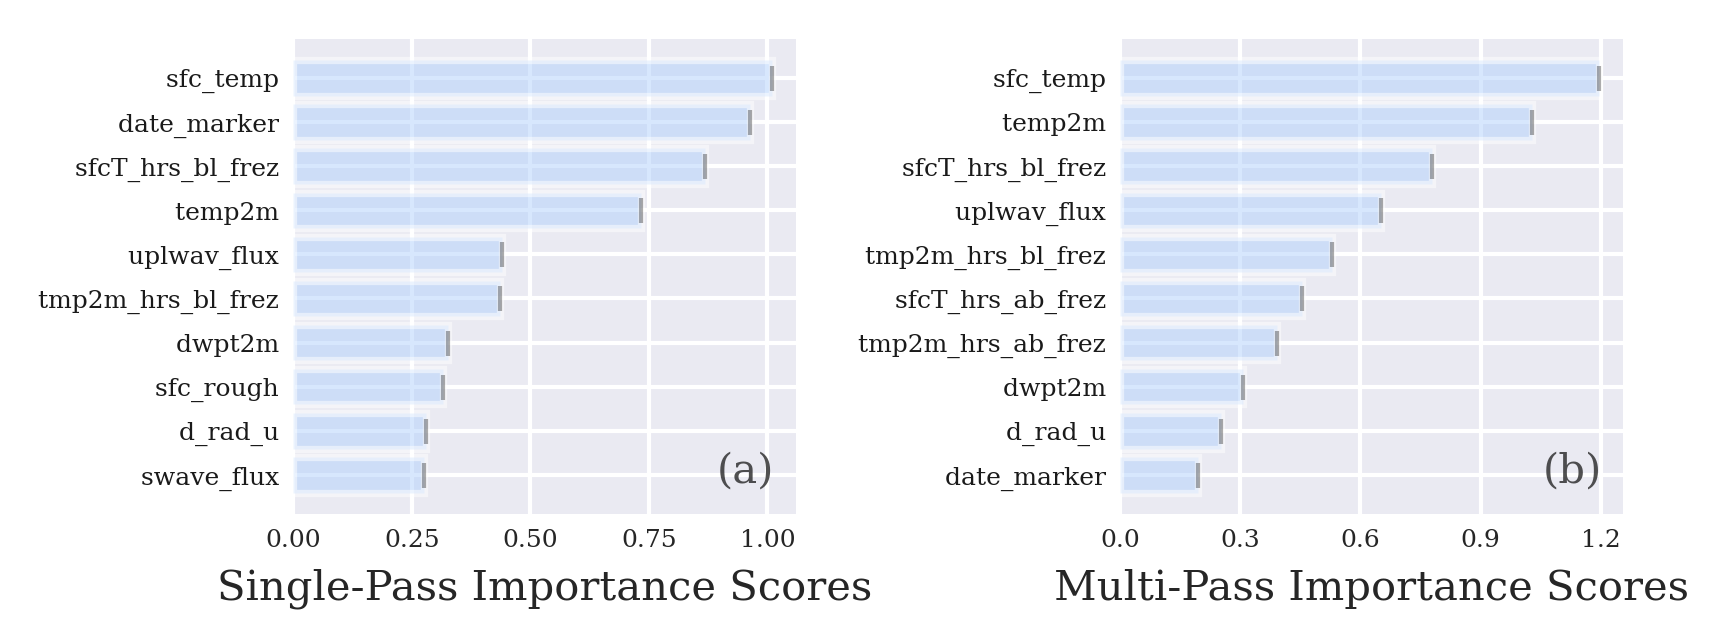

In [10]:
fig = explainer.plot_importance(data=[results]*2, 
                                panels=[('singlepass', 'Random Forest'), 
                                        ('multipass', 'Random Forest'), 
                                       ], num_vars_to_plot=10,)

## Plotting Permutation Importance (with Color Coding and Readable Predictor Names)

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). To see our example of `display_feature_names` and `feature_colors`, look in `plotting_config.py`. 

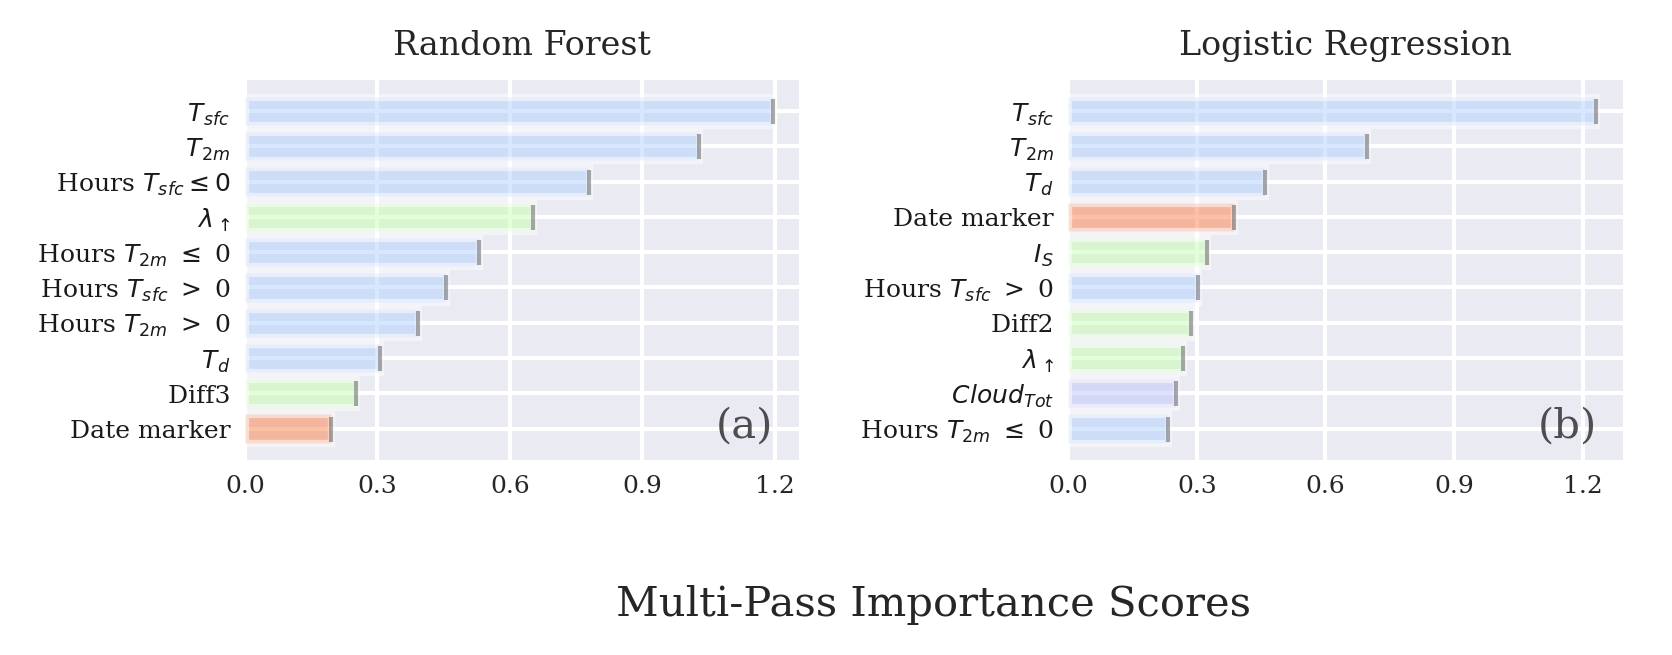

In [11]:
fig = explainer.plot_importance(data = [results]*2,
                                panels=[('multipass', 'Random Forest'), 
                                        ('multipass', 'Logistic Regression'), ], 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                   )

## Annotating Correlated Features

One limitation of the permutation importance method is the assumption that features are independent. If there are strong statistical or physical correlations between features, then the marginal-based shuffling of values can create unphysical/unrealistic examples, which will force the ML model to extrapolate. Correlated features can also distort the feature rankings. Therefore, there is a argument in `plot_importance` where we can annotate if any of the feature shown have a strong linear correlation. To use this, set `plot_correlated_features=True`. 


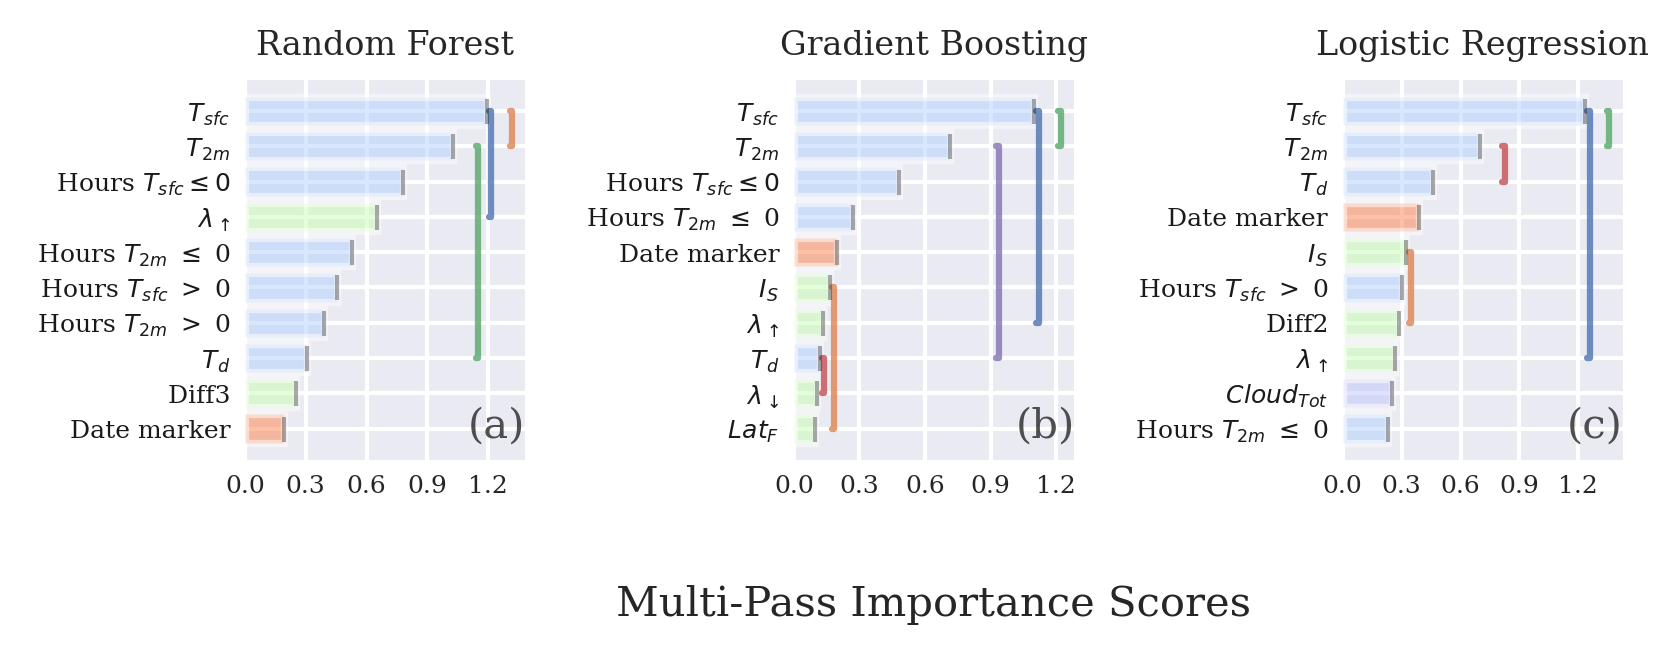

In [16]:
explainer = skexplain.ExplainToolkit(estimators,X=X, y=y,)
fig = explainer.plot_importance(data = [results]*3,
                                panels=[('multipass', 'Random Forest'), 
                                        ('multipass', 'Gradient Boosting'),
                                        ('multipass', 'Logistic Regression'), ], 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    plot_correlated_features=True,
                                    rho_threshold=0.6,
                                   )

As we can see, the random forest (panel a) has multiple correlated pairs ($\rho$ > 0.6)  in the top 10 features. Additionally, we could compute the variance inflation factor to determine if features were multicollinear. If you send in `colinear_features` into `plot_importance` those features will have blue text. 

### Plotting Permutation Importance for Multiple Metrics 

The feature ranking can be sensitive to the error metric used. We can compute the permutation importance again, but this time with Area under the Precision-Recall Curve (AUPRC; also known as Area under the Performance Diagram for meteorologists). To plot results for both metrics, set `data` to a list of both results. Also, to label each row, set the argument `ylabels`. In our case, We've set `ylabels = ['AUC', 'AUPRC']`.

In [22]:
explainer = skexplain.ExplainToolkit(estimators, X=X, y=y,)
auc_results = explainer.permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auc', 
                                               n_permute=5, 
                                               subsample=0.01,
                                               n_jobs=8,
                                              )
explainer.save(fname='multipass_importance_auc.nc', data=auc_results)

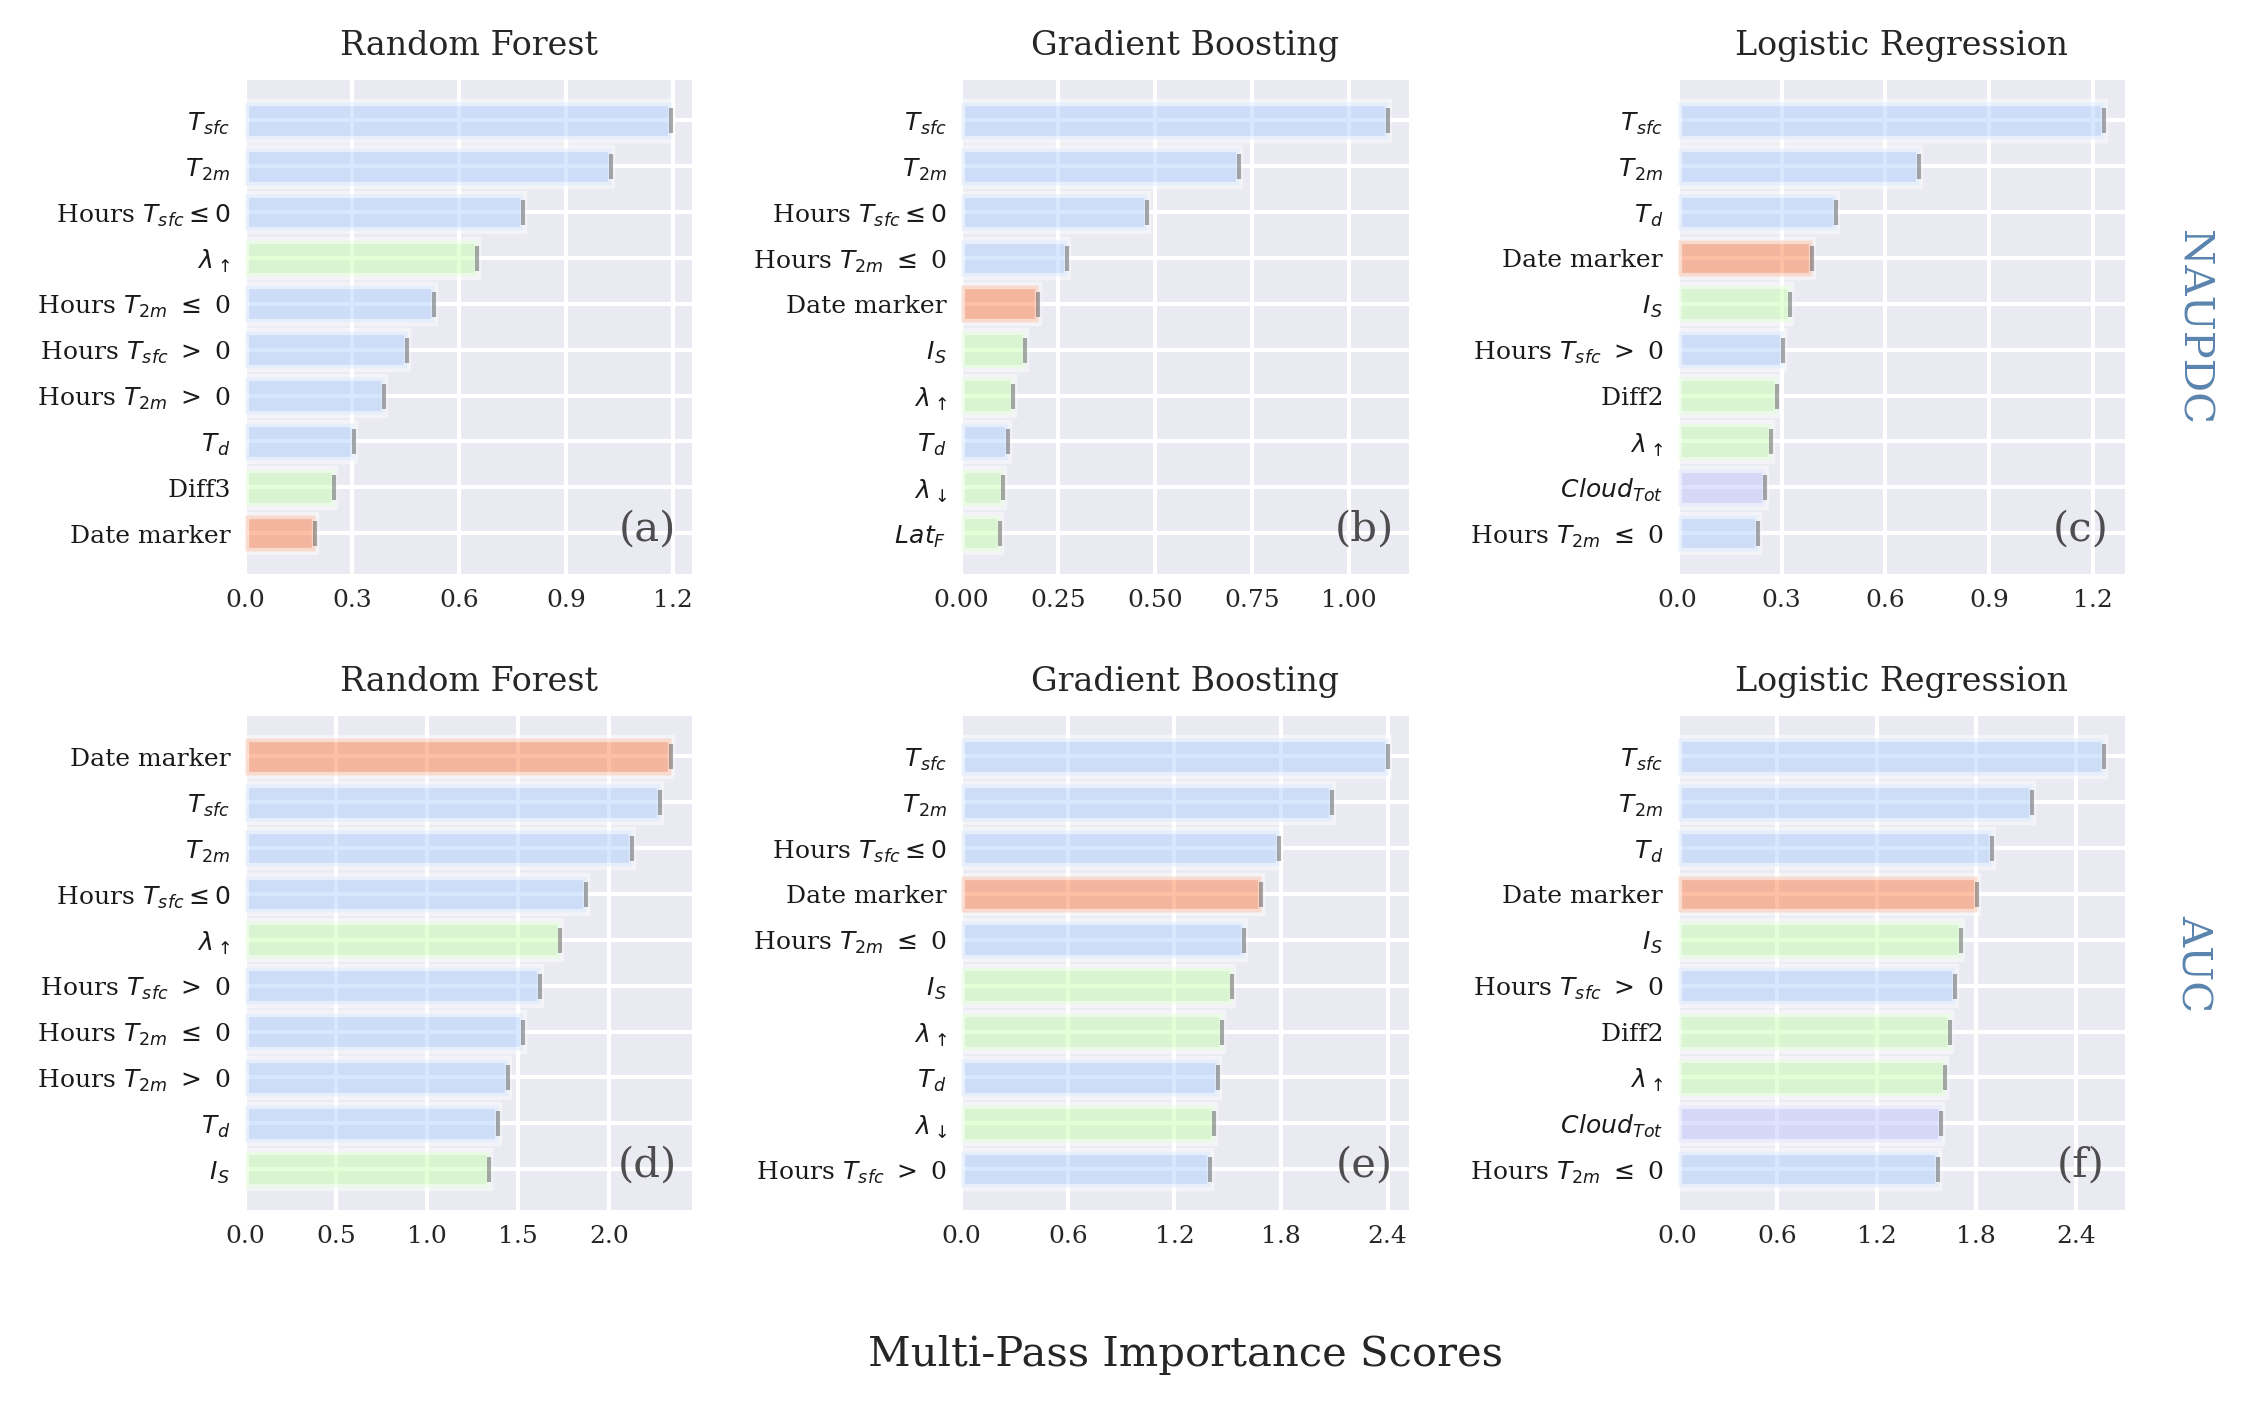

In [14]:
auc_results = explainer.load(fnames='multipass_importance_auc.nc')
fig = explainer.plot_importance(
                                 data = [results, results, results, 
                                         auc_results, auc_results, auc_results,],
                                panels=[('multipass', 'Random Forest'), 
                                        ('multipass', 'Gradient Boosting'),
                                        ('multipass', 'Logistic Regression'),
                                        ('multipass', 'Random Forest'), 
                                        ('multipass', 'Gradient Boosting'),
                                        ('multipass', 'Logistic Regression'),
                                       ],
                                 display_feature_names=plotting_config.display_feature_names,
                                 feature_colors=plotting_config.color_dict,
                                 ylabels = ['NAUPDC', 'AUC'],
                                 figsize = (8,5), 
                                 hspace = 0.4, wspace=0.3, 
                                   )

</div> <div class="alert alert-block alert-warning"><b>**Tip**: Though we have tried to generalize the multipanel plotting behavior, we realize that many people will want to fidgit with stuff. The plotting functions in scikit-explain do allow for keyword args that are passed on to the underlying matplotlib functions. For example, in the plot above, we set the figsize, hspace, and wspace to improve the figure quality. </b> 

There are some differences, but overall the feature ranking are roughly similar. This bolsters our confidence in the feature ranking and helps triangulate the most important predictors. 

## Comparing Forward vs. Backward Multi-pass Permutation Importance

In [35]:
forward_results = explainer.permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='norm_aupdc', 
                                               n_permute=10, 
                                               subsample=0.25,
                                               n_jobs=8,
                                               verbose=True,
                                                random_seed=42, 
                                               direction='forward'
                                              )

# Save the permutation importance results as a netcdf file using the bulit-in function within mintpy
explainer.save(fname='multipass_importance_forward_naupdc.nc', data=results)

Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out of 10...
Multi-pass iteration 9 out of 10...
Multi-pass iteration 10 out of 10...
Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out of 10...
Multi-pass iteration 9 out of 10...
Multi-pass iteration 10 out of 10...
Multi-pass iteration 1 out of 10...
Multi-pass iteration 2 out of 10...
Multi-pass iteration 3 out of 10...
Multi-pass iteration 4 out of 10...
Multi-pass iteration 5 out of 10...
Multi-pass iteration 6 out of 10...
Multi-pass iteration 7 out of 10...
Multi-pass iteration 8 out

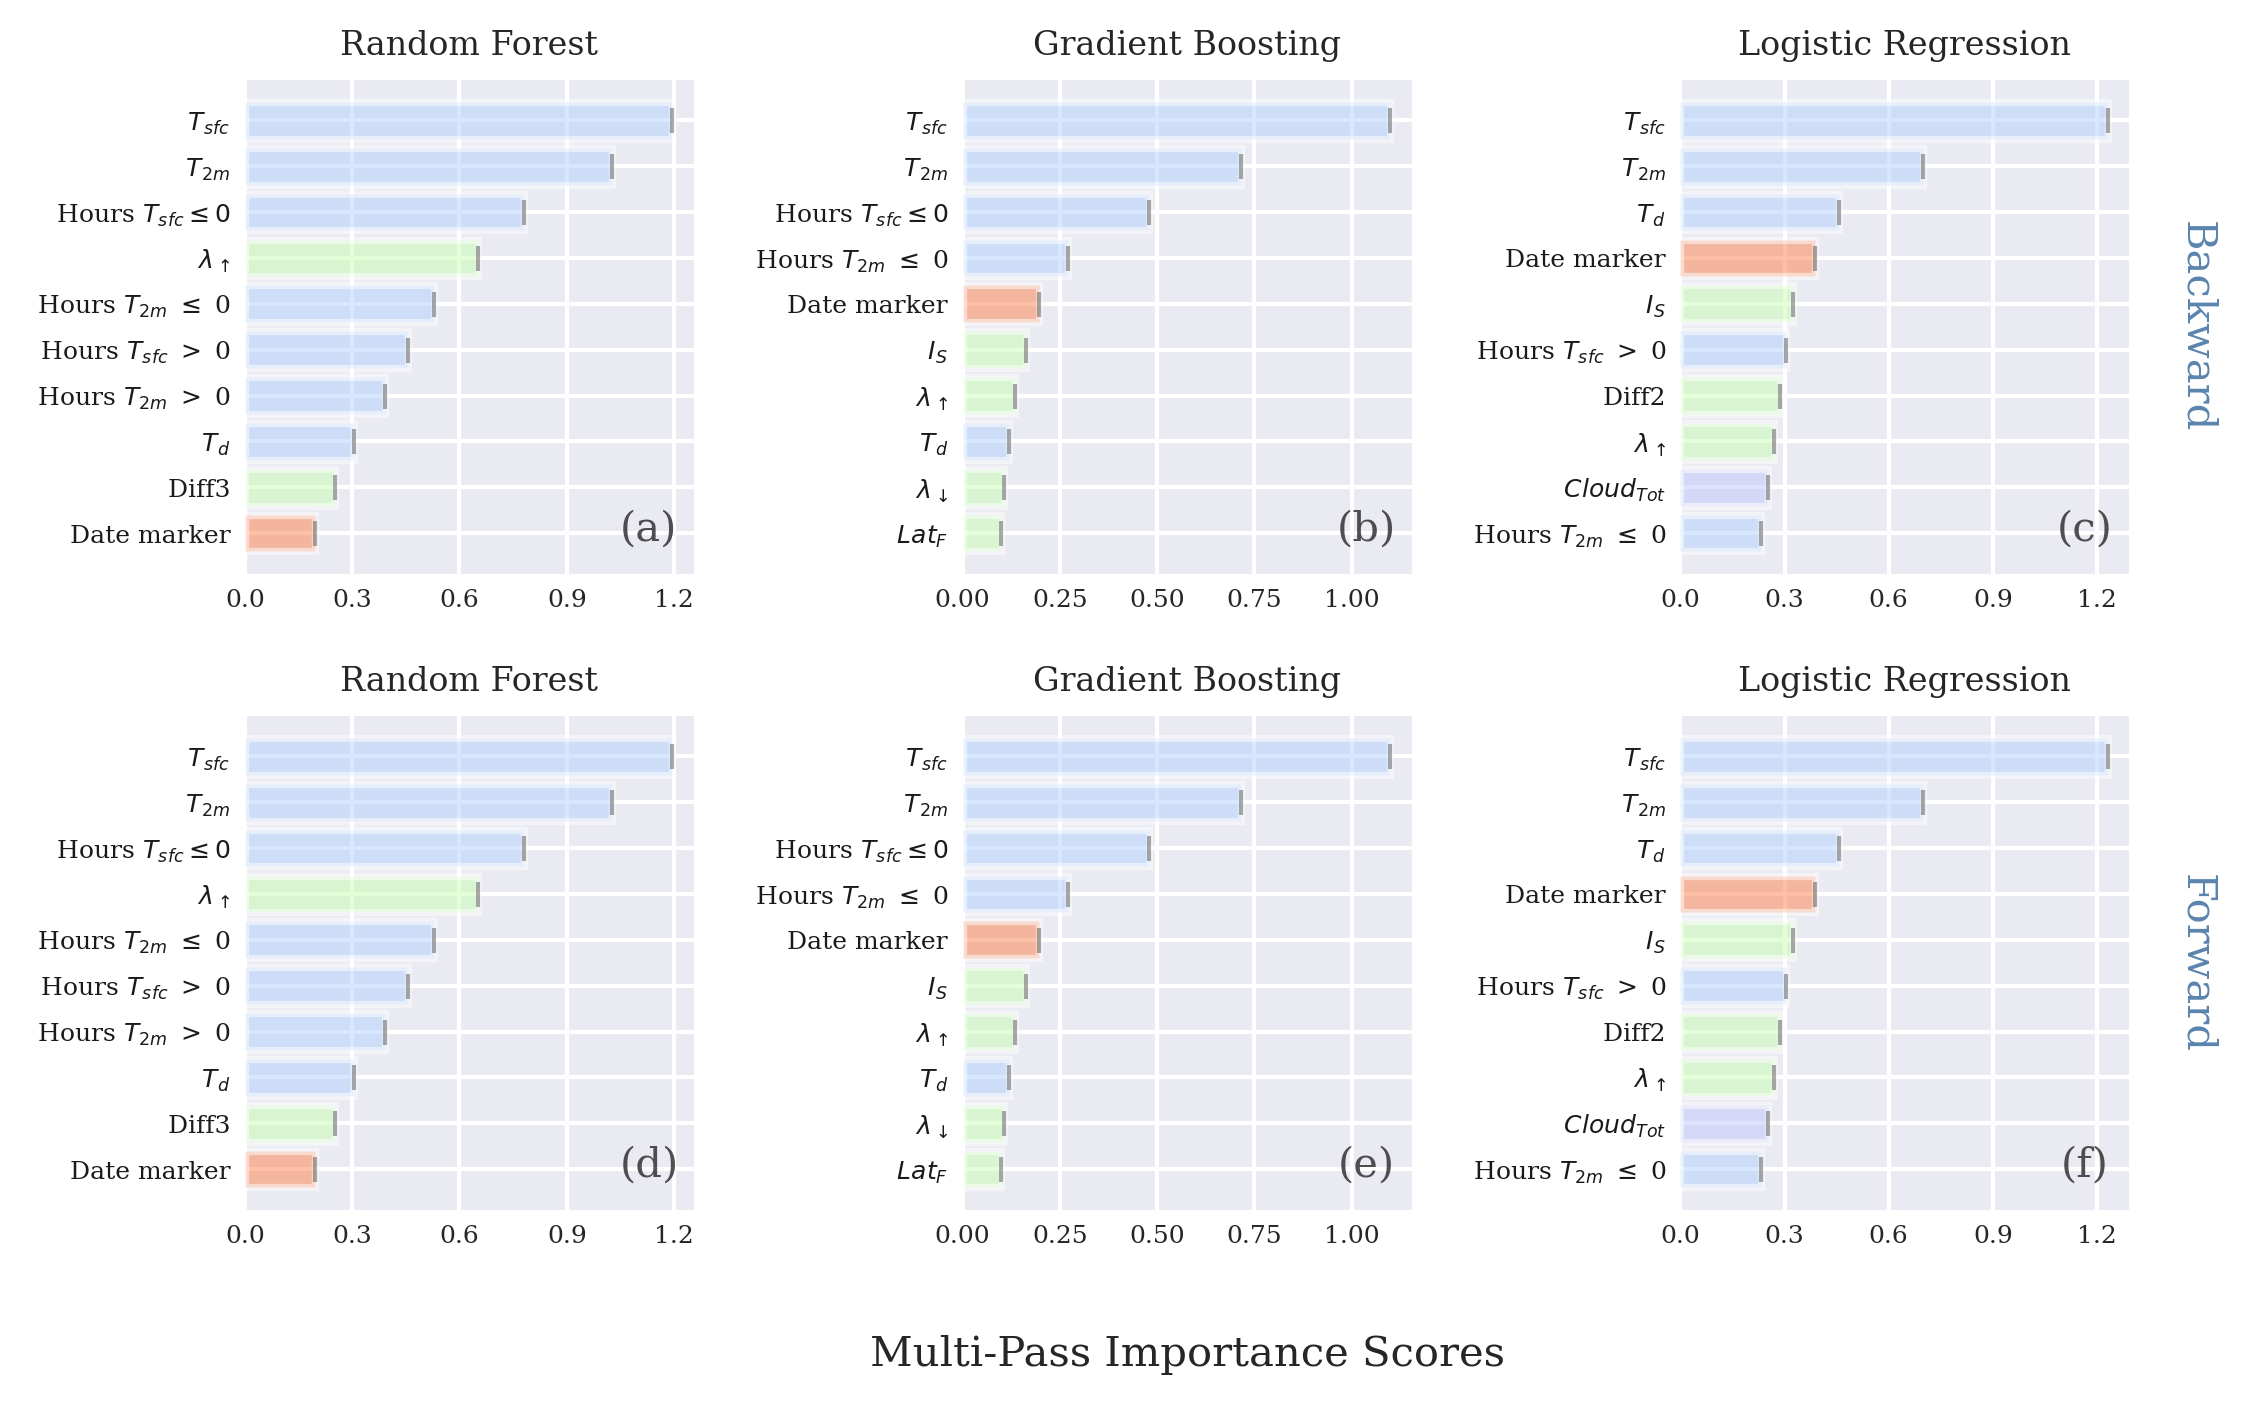

In [15]:
forward_results = explainer.load(fnames='multipass_importance_forward_naupdc.nc')
fig = explainer.plot_importance(
                                    data = [results]*3 + [forward_results]*3, 
                                panels=[('multipass', 'Random Forest'), 
                                        ('multipass', 'Gradient Boosting'),
                                        ('multipass', 'Logistic Regression'),
                                        ('multipass', 'Random Forest'), 
                                        ('multipass', 'Gradient Boosting'),
                                        ('multipass', 'Logistic Regression'),
                                       ],
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    ylabels = ['Backward', 'Forward'],
                                    figsize = (8,5), 
                                    hspace = 0.2
                                   )

## Permutation Importance for Regression Problems

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [19]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor()

In [20]:
explainer = skexplain.ExplainToolkit(('Random Forest', model),X=X,y=y,feature_names = feature_names)
reg_results = explainer.permutation_importance(
                                               n_vars=8, 
                                               evaluation_fn='mse', 
                                               n_permute=10, 
                                               subsample=0.25,
                                               n_jobs=8,
                                               verbose=True,
                                               random_seed=42, 
                                              )

Multi-pass iteration 1 out of 8...
Multi-pass iteration 2 out of 8...
Multi-pass iteration 3 out of 8...
Multi-pass iteration 4 out of 8...
Multi-pass iteration 5 out of 8...
Multi-pass iteration 6 out of 8...
Multi-pass iteration 7 out of 8...
Multi-pass iteration 8 out of 8...


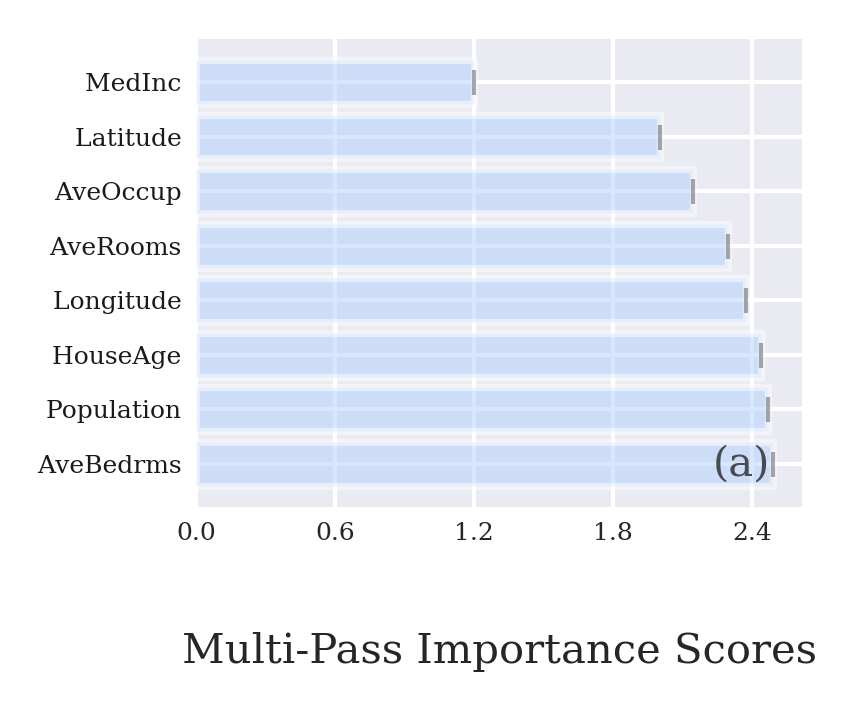

In [21]:
fig = explainer.plot_importance(data=reg_results, panels=[('multipass', 'Random Forest')], num_vars_to_plot=8)

References: 

Handler, S. L., H. D. Reeves, and A. McGovern, Development of a Probabilistic Subfreezing Road Temperature Nowcast and Forecast Using Machine Learning. Wea. Forecasting, doi: https://doi.org/10.1175/WAF-D-19-0159.1

McGovern, A., R. Lagerquist, D. John Gagne, G. E. Jergensen, K. L. Elmore, C. R. Homeyer, and T. Smith, 2019: Making the Black Box More Transparent: Understanding the Physical Implications of Machine Learning. Bull. Amer. Meteor. Soc., 100, 2175–2199, https://doi.org/10.1175/BAMS-D-18-0195.1.